In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

# Read image
files  = sorted(glob.glob("/ssd_scratch/cvit/anirudhkaushik/dataset/ISIC_2019/ISIC_2019_Training_Input/*.jpg"))
print(len(files))
# for f in tqdm.tqdm(files):
#     img = cv2.imread(f, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     # resize to 224x224
#     img = cv2.resize(img, (224, 224),cv2.INTER_AREA )
#     # save over original
#     cv2.imwrite(f, img)


25331


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet101_Weights, resnet101
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Load pretrained model
model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
# model = resnet101(weights=)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd

df_train = pd.read_csv("/ssd_scratch/cvit/anirudhkaushik/dataset/ISIC_2019/ISIC_2019_Training_GroundTruth.csv")
print(df_train.head())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


### Applying color constancy

In [4]:
def color_constancy(img, power=6, gamma=None):
    """
    Parameters
    ----------
    img: 3D np array
        The original image with format of (h, w, c)
    power: int
        The degree of norm, 6 is used in reference paper
    gamma: float
        The value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype


    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256): look_up_table[i][0] = 255*pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)


    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)
    
    return img.astype(img_dtype) 


In [5]:
from sklearn.model_selection import train_test_split
import os
def load_isic_2019(classes):
    root = "/ssd_scratch/cvit/anirudhkaushik/dataset/ISIC_2019"
    """
    Load ISIC_2019 dataset and convert it to IIRC format

    Args:
        root (string): The location of the dataset
        intask_valid_train_ratio (float): the percentage of the training set to be taken for the in-task validation set
            , a training-like validation set used for valdation during the task training (default: 0.1)
        posttask_valid_train_ratio (float): the percentage of the training set to be taken for the post-task validation
            set, a test-like validation set used for valdation after the task training (default: 0.1)

    Returns:
        Dict[str, DatasetStructType]: datasets, a dictionary with the keys corresponding to the four splits (train,
        intask_validation, posttask_validation, test), and the values being a list of the samples that belong to
        each split (with the images provided in Image.Image type) in the DatasetTypeStruct structure
    """
    raw_data_meta_df = pd.read_csv(root+'/ISIC_2019_Training_GroundTruth.csv')

    isic_data_map = {
        "MEL": "Melanoma",  
        "NV": "Melanocytic_nevus" ,
        "BCC": "Basal_cell_carcinoma",
        "AK": "Actinic_keratosis",
        "BKL": "Benign_keratosis",
        "DF": "Dermatofibroma",
        "VASC": "Vascular_lesion",
        "SCC": "Squamous_cell_carcinoma"
    }

    train_data_classwise = {class_name: [] for class_name in classes}
    test_data_classwise = {class_name: [] for class_name in classes}
    
    train_num_samples_per_class = {class_name: 0 for class_name in classes}
    test_num_samples_per_class = {class_name: 0 for class_name in classes}
    
    labels = list(raw_data_meta_df.columns[1:-1])
    class_to_idx = {isic_data_map[label]: idx for idx, label in enumerate(classes)}


    X = raw_data_meta_df.iloc[:]['image'] # only image names, not actual images
    y = raw_data_meta_df.iloc[:, 1:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

    raw_data_train = []
    for ind  in range(len(X_train)):
        img_name = X_train.iloc[ind]
        labels = y_train.iloc[ind]
        label = labels[labels == 1].index[0]
        label_name = label
        if label not in classes:
            continue            
        image = cv2.imread(os.path.join(root, "ISIC_2019_Training_Input", img_name+".jpg"), cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224), cv2.INTER_AREA) # remove later
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = color_constancy(image) 
        label = class_to_idx[isic_data_map[label]] 
        # raw_data_train.append((image, label))
        train_data_classwise[label_name].append((image, label))


    # Balance as per the class with minimum number of samples
    min_num_samples = min([len(train_data_classwise[class_name]) for class_name in classes])
    # randomly sample from other classes to make the number of samples equal to min_num_samples
    for class_name in classes:
        np.random.shuffle(train_data_classwise[class_name])
        train_data_classwise[class_name] = train_data_classwise[class_name][:min_num_samples]
        train_num_samples_per_class[class_name] = len(train_data_classwise[class_name])

    print("Train data distribution")
    for class_name in classes:
        label_name = isic_data_map[class_name]
        print("{}: {}".format(label_name, train_num_samples_per_class[class_name]))

    # insert the samples into the raw_data_train fast
    for class_name in classes:
        raw_data_train.extend(train_data_classwise[class_name])




    raw_data_test = []
    for ind  in range(len(X_test)):
        img_name = X_test.iloc[ind]
        labels = y_test.iloc[ind]
        label = labels[labels == 1].index[0]
        label_name = label
        if label not in classes:
            continue
        image = cv2.imread(os.path.join(root, "ISIC_2019_Training_Input", img_name+".jpg"), cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224), cv2.INTER_AREA) # remove later, inter area is for making it smaller, for making it larger use inter linear
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = color_constancy(image) 
        label = class_to_idx[isic_data_map[label]]
        # raw_data_test.append((image, label))
        test_data_classwise[label_name].append((image, label))

    # Balance as per the class with minimum number of samples
    min_num_samples = min([len(test_data_classwise[class_name]) for class_name in classes])
    # randomly sample from other classes to make the number of samples equal to min_num_samples
    for class_name in classes:
        np.random.shuffle(test_data_classwise[class_name])
        test_data_classwise[class_name] = test_data_classwise[class_name][:min_num_samples]
        test_num_samples_per_class[class_name] = len(test_data_classwise[class_name])

    # insert the samples into the raw_data_test fast
    for class_name in classes:
        raw_data_test.extend(test_data_classwise[class_name])

    print("Test data distribution")
    for class_name in classes:
        label_name = isic_data_map[class_name]
        print("{}: {}".format(label_name, test_num_samples_per_class[class_name]))

    return raw_data_train, raw_data_test

In [6]:
# train_nevus, test_nevus = load_isic_2019(["MEL", "NV"])
# print()
# train_bkl, test_bkl = load_isic_2019(["MEL", "BKL"])
# print()

final_train, final_test = load_isic_2019(["MEL", "NV", "BKL"])

print()

Train data distribution
Melanoma: 2361
Melanocytic_nevus: 2361
Benign_keratosis: 2361
Test data distribution
Melanoma: 263
Melanocytic_nevus: 263
Benign_keratosis: 263



In [7]:
base_model_path = "/ssd_scratch/cvit/anirudhkaushik/saved_models/"

#### Melanoma vs Nevus 
 *Note: this model was trained with dysplastic Nevus (suspected) trained without color constancy*

In [8]:
melanoma_vs_nevus_model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
melanoma_vs_nevus_model.fc = nn.Linear(2048, 2)
# melanoma_vs_nevus_model.load_state_dict(torch.load(os.path.join(base_model_path, "dysplastic_nevus_exp2.pth")))
melanoma_vs_nevus_model = torch.nn.DataParallel(melanoma_vs_nevus_model)
melanoma_vs_nevus_model = melanoma_vs_nevus_model.to(device)

#### Melanoma vs Seborrheic Keratosis
*Note: this model wil be trained from scratch*

In [9]:
melanoma_vs_benign_keratosis_model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
melanoma_vs_benign_keratosis_model.fc = nn.Linear(2048, 2)
melanoma_vs_benign_keratosis_model = torch.nn.DataParallel(melanoma_vs_benign_keratosis_model)
melanoma_vs_benign_keratosis_model = melanoma_vs_benign_keratosis_model.to(device)

### Final model
*Note: this model will be trained from scratch on all 3 classes jointly and will be used as a baseline for melanoma identification*

In [10]:
mel_nv_bkl_model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
mel_nv_bkl_model.fc = nn.Linear(2048, 3)
mel_nv_bkl_model = torch.nn.DataParallel(mel_nv_bkl_model)
mel_nv_bkl_model = mel_nv_bkl_model.to(device)

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# dataloader
class ISICDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225] )
])


In [9]:
# # mel vs nevus dataset and dataloader
# train_mel_vs_nevus_dataset = ISICDataset(train_nevus, transform=transform)
# test_mel_vs_nevus_dataset = ISICDataset(test_nevus, transform=transform)

# train_mel_vs_nevus_dataloader = DataLoader(train_mel_vs_nevus_dataset, batch_size=32, shuffle=True, num_workers=4)
# test_mel_vs_nevus_dataloader = DataLoader(test_mel_vs_nevus_dataset, batch_size=32, shuffle=True, num_workers=4)

# # mel vs bkl dataset and dataloader
# train_mel_vs_bkl_dataset = ISICDataset(train_bkl, transform=transform)
# test_mel_vs_bkl_dataset = ISICDataset(test_bkl, transform=transform)

# train_mel_vs_bkl_dataloader = DataLoader(train_mel_vs_bkl_dataset, batch_size=32, shuffle=True, num_workers=4)
# test_mel_vs_bkl_dataloader = DataLoader(test_mel_vs_bkl_dataset, batch_size=32, shuffle=True, num_workers=4)

# final dataset and dataloader
train_final_dataset = ISICDataset(final_train, transform=transform)
test_final_dataset = ISICDataset(final_test, transform=transform)

train_final_dataloader = DataLoader(train_final_dataset, batch_size=32, shuffle=True, num_workers=4)
test_final_dataloader = DataLoader(test_final_dataset, batch_size=32, shuffle=True, num_workers=4)

In [13]:


def test_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('\nTest set: Accuracy: {:.0f}%\n'.format(
            100. * correct / len(test_loader.dataset)))
    
    return correct / len(test_loader.dataset)

def train_model(model, train_loader, test_loader, optimizer, epochs):
    acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
                running_loss = 0.0
        
        acc = test_model(model, test_loader)
        acc_list.append(acc)
        loss_list.append(running_loss)

    return acc_list, loss_list



In [14]:
def classwise_acc(model, test_loader, classes):
    isic_data_map = {
        "MEL": "Melanoma",  
        "NV": "Melanocytic_nevus" ,
        "BCC": "Basal_cell_carcinoma",
        "AK": "Actinic_keratosis",
        "BKL": "Benign_keratosis",
        "DF": "Dermatofibroma",
        "VASC": "Vascular_lesion",
        "SCC": "Squamous_cell_carcinoma"
    }
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {isic_data_map[classname]:5s} is {accuracy:.1f} %')
    return [correct_pred[classname] / total_pred[classname] for classname in classes]


In [15]:
def summarise_experiment(model, acc_list, loss_list, classes, test_dataloader, save=False, save_path=None):

    # plot accuracy and loss curves
    plt.subplot(2, 1, 1)
    plt.plot(acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(loss_list)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()

    # print final test accuracy
    final_test_acc = test_model(model, test_dataloader)
    print("Final test accuracy: {:.0f}%".format(100. * final_test_acc))

    # print classwise accuracy
    classwise_score = classwise_acc(model, test_dataloader, classes)
    print("Melanoma class accuracy: {:.0f}%".format(100. * classwise_score[0]))
    print("Melanocytic Nevus class accuracy: {:.0f}%".format(100. * classwise_score[1]))

    # print mean and standard deviation of the training
    # mean and standard deviation of accuracy 
    mean = np.mean(acc_list)
    std = np.std(acc_list)
    print("Mean accuracy: {:.2f}%".format(100. * mean))
    print("Standard deviation of accuracy: {:.2f}%".format(100. * std))

    if save:
        torch.save(model.state_dict(), save_path)

#### Begin training Melanoma vs Benign keratosis model

[1,   100] loss: 0.695

Test set: Accuracy: 58%

[2,   100] loss: 0.665

Test set: Accuracy: 64%

[3,   100] loss: 0.642

Test set: Accuracy: 67%

[4,   100] loss: 0.623

Test set: Accuracy: 68%

[5,   100] loss: 0.604

Test set: Accuracy: 72%

[6,   100] loss: 0.589

Test set: Accuracy: 71%

[7,   100] loss: 0.582

Test set: Accuracy: 72%

[8,   100] loss: 0.571

Test set: Accuracy: 72%

[9,   100] loss: 0.565

Test set: Accuracy: 73%

[10,   100] loss: 0.549

Test set: Accuracy: 72%



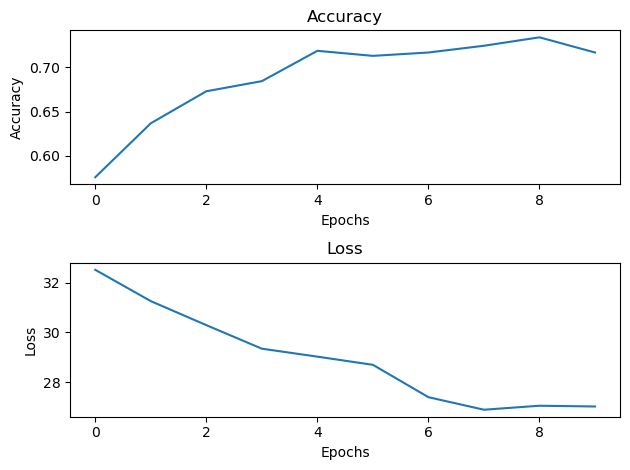


Test set: Accuracy: 72%

Final test accuracy: 72%
Accuracy for class: Melanoma is 73.8 %
Accuracy for class: Benign_keratosis is 69.6 %
Melanoma class accuracy: 74%
Melanocytic Nevus class accuracy: 70%
Mean accuracy: 68.94%
Standard deviation of accuracy: 4.69%


In [16]:
optimizer = optim.SGD(melanoma_vs_benign_keratosis_model.parameters(), lr=0.0001, momentum=0.9)
acc_list_bkl, loss_list_bkl = train_model(melanoma_vs_benign_keratosis_model, train_mel_vs_bkl_dataloader, test_mel_vs_bkl_dataloader, optimizer, 10)
summarise_experiment(melanoma_vs_benign_keratosis_model,acc_list_bkl, loss_list_bkl,["MEL", "BKL"] , test_mel_vs_bkl_dataloader, save=True, save_path=os.path.join(base_model_path, "melanoma_screening_exp1_mel_vs_bkl.pth"))

#### Train final model 
 - Trained on melanoma vs benign keratosis vs Nevus

[1,   100] loss: 1.078
[1,   200] loss: 1.049

Test set: Accuracy: 54%

[2,   100] loss: 1.026
[2,   200] loss: 0.992

Test set: Accuracy: 56%

[3,   100] loss: 0.973
[3,   200] loss: 0.957

Test set: Accuracy: 58%

[4,   100] loss: 0.923
[4,   200] loss: 0.923

Test set: Accuracy: 61%

[5,   100] loss: 0.915
[5,   200] loss: 0.875

Test set: Accuracy: 61%

[6,   100] loss: 0.875
[6,   200] loss: 0.872

Test set: Accuracy: 62%

[7,   100] loss: 0.859
[7,   200] loss: 0.856

Test set: Accuracy: 64%

[8,   100] loss: 0.851
[8,   200] loss: 0.820

Test set: Accuracy: 64%

[9,   100] loss: 0.827
[9,   200] loss: 0.834

Test set: Accuracy: 66%

[10,   100] loss: 0.815
[10,   200] loss: 0.809

Test set: Accuracy: 64%



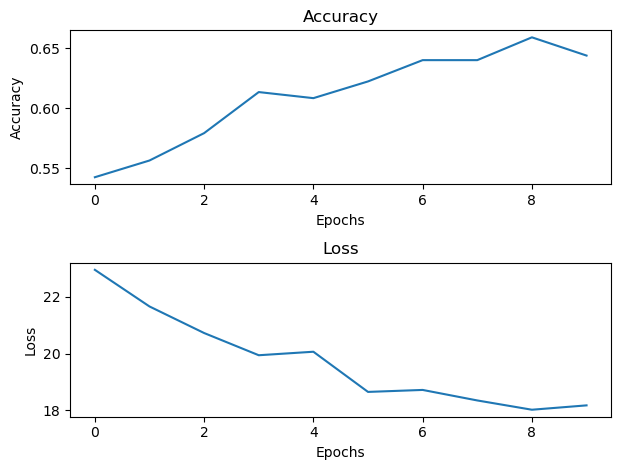


Test set: Accuracy: 64%

Final test accuracy: 64%
Accuracy for class: Melanoma is 60.1 %
Accuracy for class: Melanocytic_nevus is 73.4 %
Accuracy for class: Benign_keratosis is 59.7 %
Melanoma class accuracy: 60%
Melanocytic Nevus class accuracy: 73%
Mean accuracy: 61.05%
Standard deviation of accuracy: 3.73%


In [17]:
optimizer = optim.SGD(mel_nv_bkl_model.parameters(), lr=0.0001, momentum=0.9)
acc_list_final, loss_list_final = train_model(mel_nv_bkl_model, train_final_dataloader, test_final_dataloader, optimizer, 10)
summarise_experiment(mel_nv_bkl_model, acc_list_final, loss_list_final, ["MEL", "NV", "BKL"], test_final_dataloader, save=True, save_path=os.path.join(base_model_path, "melanoma_screening_exp1_mel_nv_bkl.pth"))

#### Train Melanoma vs Melanocytic nevus
 - Trained on melanoma vs Nevus
 - Finetuned for color constancy

[1,   100] loss: 0.698
[1,   200] loss: 0.657

Test set: Accuracy: 71%

[2,   100] loss: 0.613
[2,   200] loss: 0.593

Test set: Accuracy: 74%

[3,   100] loss: 0.567
[3,   200] loss: 0.559

Test set: Accuracy: 74%

[4,   100] loss: 0.536
[4,   200] loss: 0.535

Test set: Accuracy: 75%

[5,   100] loss: 0.513
[5,   200] loss: 0.526

Test set: Accuracy: 76%



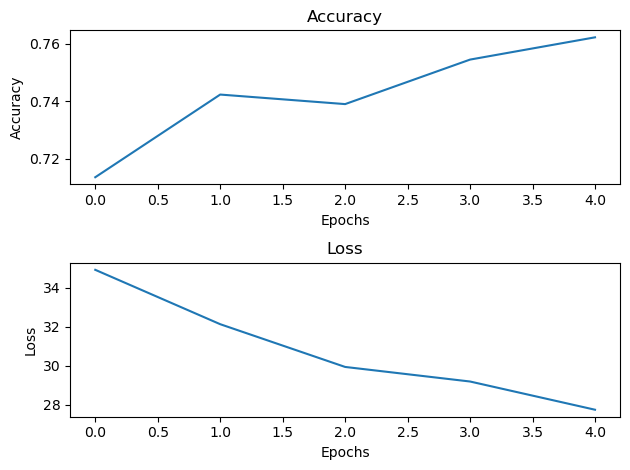


Test set: Accuracy: 76%

Final test accuracy: 76%
Accuracy for class: Melanoma is 77.0 %
Accuracy for class: Melanocytic_nevus is 75.4 %
Melanoma class accuracy: 77%
Melanocytic Nevus class accuracy: 75%
Mean accuracy: 74.23%
Standard deviation of accuracy: 1.66%


In [18]:
optimizer = optim.SGD(melanoma_vs_nevus_model.parameters(), lr=0.0001, momentum=0.9)
acc_list_nv, loss_list_nv = train_model(melanoma_vs_nevus_model, train_mel_vs_nevus_dataloader, test_mel_vs_nevus_dataloader, optimizer, 5) # only for finetuning with color constancy
summarise_experiment(melanoma_vs_nevus_model, acc_list_nv, loss_list_nv, ["MEL", "NV"], test_mel_vs_nevus_dataloader, save=True, save_path=os.path.join(base_model_path, "melanoma_screening_exp1_mel_vs_nv.pth"))

### Ensemble v1.1
#### *Salient Features*
 1. New Decision making system based on medical literature
 2. Human engineered tie-breaking and decision making
#### *Decision Making Procedure*
 1. If Melanoma vs Nevus model predicts Nevus, and Benign Keratosis vs Melanoma model predicts Melanoma, then classify as Nevus since a nevus sample would look like a Melanoma sample to the Benign Keratosis vs Melanoma model
 2. If Melanoma vs Nevus model predicts Melanoma and Benign Keratosis model predicts Benign Keratosis, then classify as Benign Keratosis as Benign Keratosis model can distinguish between Melanoma and Benign Keratosis reasonably well
 3. If Melanoma vs Nevus model predicts Melanoma and Benign Keratosis model predicts Melanoma then it is very likely to be Melanoma
 4. If Melanoma vs Nevus model predicts Nevus and Benign Keratosis model predicts Benign Keratosis then there is an ambiguity for the sample, it is most certainly not Melanoma. Since a Nevus sample would appear to be Melanoma to BKL classifier, in case of such an ambiguity, we classify the sample as Benign Keratosis

In [10]:
class Ensemble_Decision_maker():
    def __init__(self, nevus_classifier, bkl_classifier):
        self.nevus_classifier = nevus_classifier
        self.bkl_classifier = bkl_classifier

        self.nevus_classifier.eval()
        self.bkl_classifier.eval()

        self.nevus_interp = {0: "Melanoma", 1: "Melanocytic Nevus"}
        self.bkl_interp = {0: "Melanoma", 1: "Benign Keratosis"}

        self.get_probability = nn.Softmax(dim=1)

    def __call__(self, x):
        with torch.no_grad():
            nevus_output = self.nevus_classifier(x)
            bkl_output = self.bkl_classifier(x)

            nevus_pred = nevus_output.argmax(dim=1, keepdim=True)
            bkl_pred = bkl_output.argmax(dim=1, keepdim=True)

            nevus_interpretation = self.nevus_interp[nevus_pred.item()]
            bkl_interpretation = self.bkl_interp[bkl_pred.item()]
            nv_prob = self.get_probability(nevus_output)
            bkl_prob = self.get_probability(bkl_output)

            mel_prob_nv = nv_prob[0][0].item()
            mel_prob_bkl = bkl_prob[0][0].item()
            nv_prob = nv_prob[0][1].item()
            bkl_prob = bkl_prob[0][1].item()
                # print(f"Model thinks it is {nevus_interpretation}")

            # if nv model says its nevus and bkl model says its melanoma then its probably nevus
            if nevus_interpretation == "Melanocytic Nevus" and bkl_interpretation == "Melanoma":
                return nv_prob, "Melanocytic Nevus"
            
            # if bkl model says its bkl and nv model says its melanoma then its probably bkl
            elif bkl_interpretation == "Benign Keratosis" and nevus_interpretation == "Melanoma":
                return bkl_prob, "Benign Keratosis"
             
            # if both models say its melanoma then its probably melanoma
            elif nevus_interpretation == "Melanoma" and bkl_interpretation == "Melanoma":
                return mel_prob_nv, "Melanoma" # we return the nevus classifier's probability since it is the most likely to have an ambiguous output
            
            # if nv model says nv and bkl model says bkl then its probably bkl
            elif nevus_interpretation == "Melanocytic Nevus" and bkl_interpretation == "Benign Keratosis":
                return mel_prob_bkl, "Benign Keratosis"

                



#### Initialize Ensemble Decision Maker

In [11]:
melanoma_vs_nevus_model = resnet101()
melanoma_vs_nevus_model.fc = nn.Linear(2048, 2)
melanoma_vs_nevus_model = torch.nn.DataParallel(melanoma_vs_nevus_model)
melanoma_vs_nevus_model.load_state_dict(torch.load(os.path.join(base_model_path, "melanoma_screening_exp1_mel_vs_nv.pth")))
melanoma_vs_nevus_model = melanoma_vs_nevus_model.to(device)

melanoma_vs_benign_keratosis_model = resnet101()
melanoma_vs_benign_keratosis_model.fc = nn.Linear(2048, 2)
melanoma_vs_benign_keratosis_model = torch.nn.DataParallel(melanoma_vs_benign_keratosis_model)
melanoma_vs_benign_keratosis_model.load_state_dict(torch.load(os.path.join(base_model_path, "melanoma_screening_exp1_mel_vs_bkl.pth")))
melanoma_vs_benign_keratosis_model = melanoma_vs_benign_keratosis_model.to(device)

ensemble_decision_maker = Ensemble_Decision_maker(melanoma_vs_nevus_model, melanoma_vs_benign_keratosis_model)

In [12]:
print(melanoma_vs_benign_keratosis_model)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [13]:
### evaluate on 10 images from the final test set (randomly sampled)
import copy
isic_data_map = {
    "MEL": "Melanoma",  
    "NV": "Melanocytic Nevus" ,
    "BCC": "Basal_cell_carcinoma",
    "AK": "Actinic_keratosis",
    "BKL": "Benign Keratosis",
    "DF": "Dermatofibroma",
    "VASC": "Vascular_lesion",
    "SCC": "Squamous_cell_carcinoma"
}
classes = {0: "MEL", 1: "NV", 2: "BKL"}
copy_dataset = copy.deepcopy(test_final_dataset)
choices = np.arange(len(copy_dataset))

classwise_accuracies = {0: 0, 1: 0, 2: 0}
total_pred = {0: 0, 1: 0, 2: 0}
# np.random.shuffle(choices)
for i in range(len(copy_dataset)):
    image, label = copy_dataset[i]
    image = image.to(device)
    
    prob, prediction = ensemble_decision_maker(image.unsqueeze(0))
    if(i%50 == 0):
        print(f"Prediction: {prediction} | Probability: {prob}")
    if prediction == isic_data_map[classes[label]]:
        classwise_accuracies[label] += 1

    total_pred[label] += 1
    
    # print(f"Ground truth: {isic_data_map[classes[label]]}")
    # print("")

print(f"Melanoma accuracy: {classwise_accuracies[0] / total_pred[0]}")
print(f"Nevus accuracy: {classwise_accuracies[1] / total_pred[1]}")
print(f"Benign Keratosis accuracy: {classwise_accuracies[2] / total_pred[2]}")





Prediction: Melanoma | Probability: 0.940310001373291
Prediction: Melanoma | Probability: 0.6226637959480286
Prediction: Benign Keratosis | Probability: 0.5955658555030823
Prediction: Melanoma | Probability: 0.8474779725074768
Prediction: Melanoma | Probability: 0.8575454950332642
Prediction: Melanoma | Probability: 0.54491126537323
Prediction: Benign Keratosis | Probability: 0.2921798825263977
Prediction: Melanoma | Probability: 0.6425812840461731
Prediction: Benign Keratosis | Probability: 0.23579207062721252
Prediction: Melanocytic Nevus | Probability: 0.5654572248458862
Prediction: Melanocytic Nevus | Probability: 0.6069971919059753
Prediction: Benign Keratosis | Probability: 0.24143831431865692
Prediction: Melanoma | Probability: 0.8497156500816345
Prediction: Benign Keratosis | Probability: 0.4951179027557373
Prediction: Melanoma | Probability: 0.8447654843330383
Prediction: Benign Keratosis | Probability: 0.19252249598503113
Melanoma accuracy: 0.5893536121673004
Nevus accuracy: 

### Confusion Matrix

In [35]:
#Confusion Matrix
import copy
isic_data_map = {
    "MEL": "Melanoma",  
    "NV": "Melanocytic Nevus" ,
    "BCC": "Basal_cell_carcinoma",
    "AK": "Actinic_keratosis",
    "BKL": "Benign Keratosis",
    "DF": "Dermatofibroma",
    "VASC": "Vascular_lesion",
    "SCC": "Squamous_cell_carcinoma"
}
classes = {0: "MEL", 1: "NV", 2: "BKL"}
pred_interp = {"Melanoma":0 , "Melanocytic Nevus":1, "Benign Keratosis":2}
copy_dataset = copy.deepcopy(test_final_dataset)
choices = np.arange(len(copy_dataset))

classwise_accuracies = {0: 0, 1: 0, 2: 0}
total_pred = {0: 0, 1: 0, 2: 0}

confusion_matrix = np.zeros((3,3))

mel_classified_as_nv = []
mel_classified_as_bkl = []

# np.random.shuffle(choices)
for i in range(len(copy_dataset)):
    image, label = copy_dataset[i]
    image = image.to(device)
    
    prob, prediction = ensemble_decision_maker(image.unsqueeze(0))
    if(i%50 == 0):
        print(f"Prediction: {prediction} | Probability: {prob}")
    if prediction == isic_data_map[classes[label]]:
        classwise_accuracies[label] += 1
    if label == 0 and prediction == "Melanocytic Nevus":
        mel_classified_as_nv.append(i)
    if label == 0 and prediction == "Benign Keratosis":
        mel_classified_as_bkl.append(i)
    
    confusion_matrix[label][pred_interp[prediction]] += 1

    total_pred[label] += 1
    
    # print(f"Ground truth: {isic_data_map[classes[label]]}")
    # print("")
# convert to percentages
confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1, keepdims=True)
# display confusion matrix as a df table
confusion_matrix = pd.DataFrame(confusion_matrix, index=classes.values(), columns=classes.values())
display(confusion_matrix)
print(f"Melanoma accuracy: {classwise_accuracies[0] / total_pred[0]}")
print(f"Nevus accuracy: {classwise_accuracies[1] / total_pred[1]}")
print(f"Benign Keratosis accuracy: {classwise_accuracies[2] / total_pred[2]}")





Prediction: Melanoma | Probability: 0.940310001373291
Prediction: Melanoma | Probability: 0.6226637959480286
Prediction: Benign Keratosis | Probability: 0.5955658555030823
Prediction: Melanoma | Probability: 0.8474779725074768
Prediction: Melanoma | Probability: 0.8575454950332642
Prediction: Melanoma | Probability: 0.54491126537323
Prediction: Benign Keratosis | Probability: 0.2921798825263977
Prediction: Melanoma | Probability: 0.6425812840461731
Prediction: Benign Keratosis | Probability: 0.23579207062721252
Prediction: Melanocytic Nevus | Probability: 0.5654572248458862
Prediction: Melanocytic Nevus | Probability: 0.6069971919059753
Prediction: Benign Keratosis | Probability: 0.24143831431865692
Prediction: Melanoma | Probability: 0.8497156500816345
Prediction: Benign Keratosis | Probability: 0.4951179027557373
Prediction: Melanoma | Probability: 0.8447654843330383
Prediction: Benign Keratosis | Probability: 0.19252249598503113


,MEL,NV,BKL
MEL,0.589354,0.163498,0.247148
NV,0.133080,0.422053,0.444867
BKL,0.254753,0.049430,0.695817


Melanoma accuracy: 0.5893536121673004
Nevus accuracy: 0.4220532319391635
Benign Keratosis accuracy: 0.6958174904942965


## Visualizations

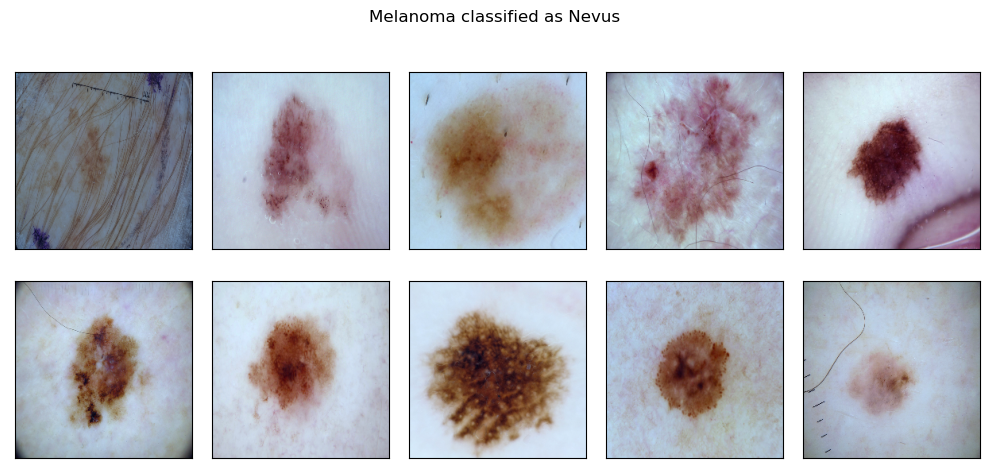

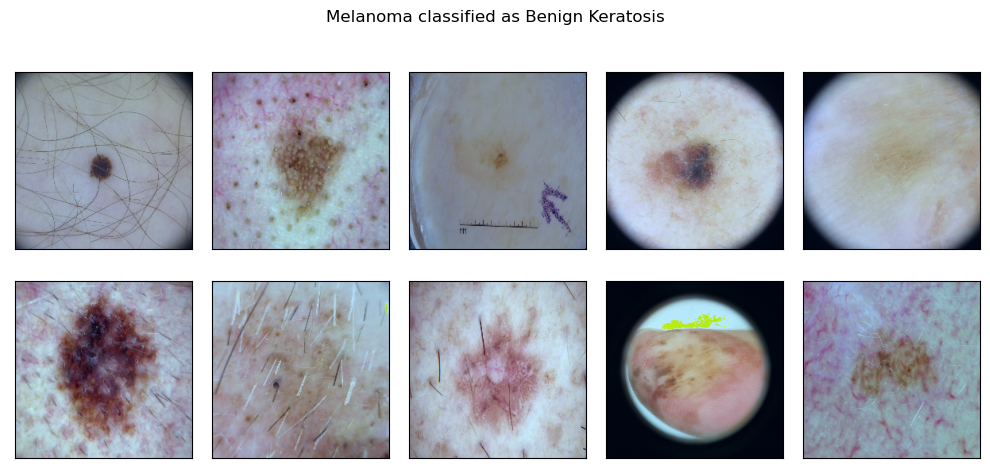

In [36]:
classes = {1: "Benign Keratosis", 0: "Melanocytic Nevus"}
random_sampler_nv = torch.utils.data.RandomSampler(mel_classified_as_nv, num_samples=10, replacement=False)
random_sampler_bkl = torch.utils.data.RandomSampler(mel_classified_as_bkl, num_samples=10, replacement=False)
# plot these 10 images with their labels in a grid
# set title of the figure
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Melanoma classified as Nevus")
for i, idx in enumerate(random_sampler_nv):
    img, label = copy_dataset[mel_classified_as_nv[idx]]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # normalize
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Melanoma classified as Benign Keratosis")
for i, idx in enumerate(random_sampler_bkl):
    img, label = copy_dataset[mel_classified_as_bkl[idx]]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # normalize
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

